# Overview

In this notebook we are going to use PyTorch to generate a simple training model for a Linear Regression problem. 

This is going to introduce the basic concepts of training a model using PyTorch, and how to use the PyTorch API to create a simple model. This is a very simple example but will allow us to get an good overview of how we build and train models using PyTorch, this workflow will be similar for other more complex models.

## Getting started

The main steps we are going to use are :

1. Prepare and load the data
2. Build a Model
3. Fit model to data (Training)
4. Evaluate the model (Testing / prediction) inference
5. Save the model

We will start by importing the python models we need. For this example we will only train on the CPU for ease (as it is a small dataset) but in practice you would use a GPU for larger datasets.


In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

print(torch.__version__)

2.6.0


## Linear Regression

In this example we are going to use the equation of a line to generate some data, and then try to fit a line to this data. The equation of a line is given by:

$$y = mx + c$$

Where $m$ is the slope of the line and $c$ is the y-intercept. In our case we will call the slope a weight and the y-intercept a bias.

The following code generates some data and place it into a Tensor. 


In [2]:
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.01
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

print(X.shape, y.shape)

torch.Size([100, 1]) torch.Size([100, 1])


We are going to split this data into a training and testing set, and then train a model to predict the slope and y-intercept of the line. We can split it in a number of ways typically we use an 80 / 20 split for training and testing, at it's simples level we can use the slice operator to split the data. with the first 80% of the data used for training and the last 20% used for testing.



In [3]:
# Use the data length to split the data into 80 / 20 train / test
train_split = int(0.8 * len(X))
X_train = X[:train_split]
X_test = X[train_split:]

y_train = y[:train_split]
y_test = y[train_split:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([80, 1]) torch.Size([20, 1]) torch.Size([80, 1]) torch.Size([20, 1])


We can now plot the data to see what it looks like. As we are going to do this a lot we can generate a simple function to plot the data (both the training and testing data) and the line that we are going to fit to the data.

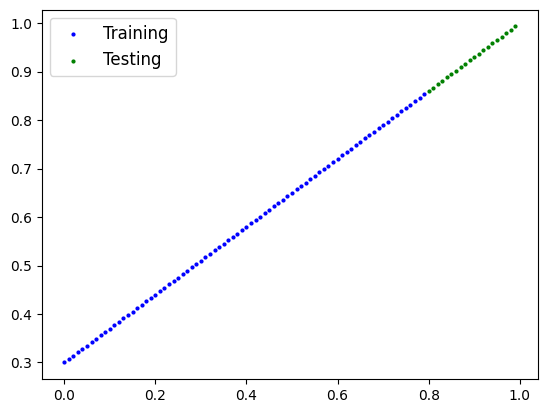

In [4]:
# This function will allow use to plot our data and later the predictions
def plot_data(train_data, train_labels, test_data, test_labels, predictions=None):
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    # Show the legend
    plt.legend(prop={"size": 12})


# Plot the data
plot_data(X_train, y_train, X_test, y_test)

## Building a Model

Now we have our testing and training data we can begin to build our model and train it. In the end we hope to get to the same weights and bias that we used to generate the data.

We are going to use the nn.Module from PyTorch as a base class and build our model on top of this.  The following code shows how to build a simple linear regression model. (same as the equation of a line)

In [5]:
class LRModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

    # this is the forward pass of the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

As you can see this model is representing the equation of a line, with the weights and bias as the parameters, they are set to be randomly initialized. The forward function is the function that is called when we pass data through the model.

The nn.Parameter is a special type of Tensor that tells PyTorch that this is a parameter of the model that needs to be updated during training, the requires_grad=True tells PyTorch to calculate the gradients of this parameter during backpropagation. 

We can now build our model and pass some data through it to see what the output looks like. In the following case we are going to set the random seed to ensure that we get the same output each time we run the code. We can use the model.parameters() function to get the parameters of the model.

In [6]:
torch.manual_seed(42)
model = LRModel()

print(f"{list(model.parameters())=}")
print(model.state_dict())

list(model.parameters())=[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]
OrderedDict({'weights': tensor([0.3367]), 'bias': tensor([0.1288])})


These two functions can be useful to see the state of our model before and after training.

## Making Predictions

The next thing we need to do is to make predictions using our model. We can do this by passing the data through the model and getting the output. We can then plot the data and the line that the model has generated.

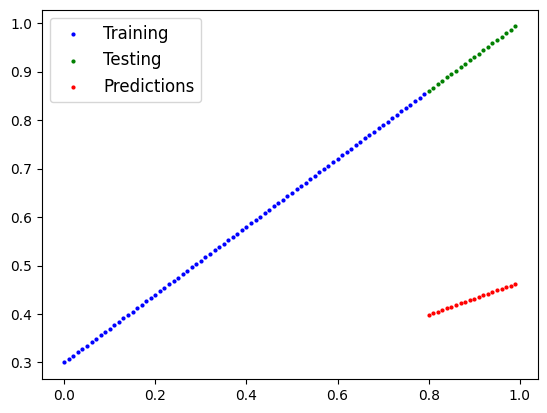

In [7]:
with torch.inference_mode():
    y_preds = model(X_test)

# we can now plot this and see how close we are (not very close)
plot_data(X_train, y_train, X_test, y_test, y_preds)

As we can see we are nowhere near the line that we used to generate the data. This is because we have not trained the model yet. We can use the model to make predictions by passing the data through the model and getting the output.

## Training the Model

At present we have a random starting prediction, what we need to do is to train the model to get the correct weights and bias, what we do is check how close we are then use an optimization algorithm to update the weights and bias to get a better prediction.

To do this we need a loss function and an optimizer. The loss function is a measure of how close we are to the correct answer, in this case we are going to use the Mean Squared Error (MSE) loss function. The optimizer is the algorithm that we are going to use to update the weights and bias, in this case we are going to use the Stochastic Gradient Descent (SGD) optimizer, for other problems we would use different optimizers, this is part of the ML workflow to find the best optimizer for the problem.

In this case we will use Mean absolute error (MAE, in PyTorch: `torch.nn.L1Loss`) which measures the absolute difference between two points.

And we'll use SGD, `torch.optim.SGD(params, lr)` which is a simple optimizer that updates the weights and bias using the gradients of the loss function.

In code this is quite simple to setup 

In [8]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

The optimizer is passed the model parmeters which it will adjust during training, and the learning rate which is a hyperparameter that controls how much we update the weights and bias during training.

## Training loop

Next we will build a training loop, this process is more or less the same for all NN models, we will pass the data through the model, calculate the loss, calculate the gradients of the loss with respect to the parameters, update the parameters using the optimizer, and then zero the gradients.


In [9]:
# how long to train for
epochs = 100

# we will use these to plot the loss values later
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    # when we train we need to put the model in training mode
    model.train()
    # grab our predictions using the training data
    y_pred = model(X_train)
    # now see how close we are to the actual values using the loss function
    loss = loss_fn(y_pred, y_train)
    # Zero grad of the optimizer (so we don't accumulate gradients)
    optimizer.zero_grad()
    # back propagate the loss
    loss.backward()
    # update the weights
    optimizer.step()

    # now test the model to see how well it's doing
    # Put the model in evaluation mode
    model.eval()

    with torch.inference_mode():
        #  forward pass on test data
        test_pred = model(X_test)

        # Calculate loss on test data
        test_loss = loss_fn(test_pred, y_test.type(torch.float))

        # Print out what's happening
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch:02d} |  Train Loss: {loss} |  Test Loss: {test_loss} ")

Epoch: 00 |  Train Loss: 0.31469789147377014 |  Test Loss: 0.48281747102737427 
Epoch: 10 |  Train Loss: 0.19909533858299255 |  Test Loss: 0.3474649488925934 
Epoch: 20 |  Train Loss: 0.08958515524864197 |  Test Loss: 0.21752354502677917 
Epoch: 30 |  Train Loss: 0.05288771539926529 |  Test Loss: 0.1439102590084076 
Epoch: 40 |  Train Loss: 0.045192889869213104 |  Test Loss: 0.11271439492702484 
Epoch: 50 |  Train Loss: 0.04140976443886757 |  Test Loss: 0.09821617603302002 
Epoch: 60 |  Train Loss: 0.03795855492353439 |  Test Loss: 0.0888485461473465 
Epoch: 70 |  Train Loss: 0.034532513469457626 |  Test Loss: 0.08085694909095764 
Epoch: 80 |  Train Loss: 0.03110707364976406 |  Test Loss: 0.07252134382724762 
Epoch: 90 |  Train Loss: 0.027681410312652588 |  Test Loss: 0.06452975422143936 


We can plot these results to see what happens per epoch as follows :

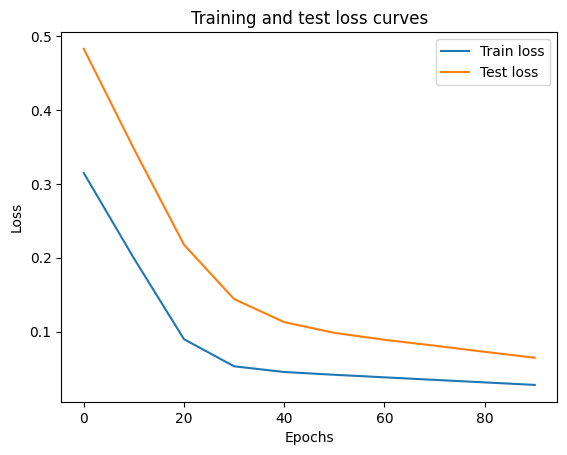

In [10]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

It looks like we are getting close, we can see what the model parameters are after training, and then make predictions using the model.

In [11]:
print(model.state_dict())
print(f"weights: {weight}, bias: {bias}")

OrderedDict({'weights': tensor([0.5792]), 'bias': tensor([0.3508])})
weights: 0.7, bias: 0.3


You can see we are close but not quite there, this is because we have not trained for long enough, we can increase the number of epochs to get a better fit. Note if we change the code to add more epochs we may need to re-start the kernel to re-run the code. This is due to the way that PyTorch works with the computational graph and the way that the gradients are calculated.

## Making Predictions

We can now make some predictions using the model and plot the results. We can see that the model is now very close to the line that we used to generate the data.

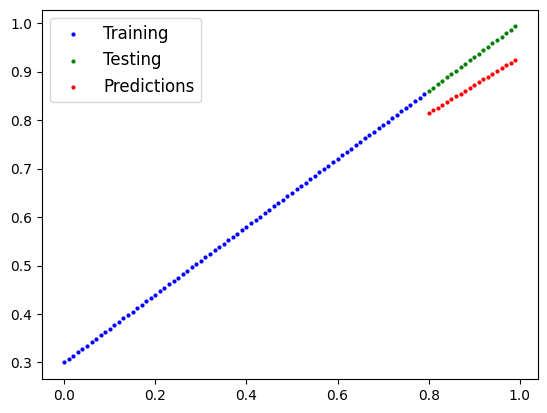

In [12]:
# 1. Set the model in evaluation mode
model.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
    y_preds = model(X_test)

plot_data(X_train, y_train, X_test, y_test, y_preds)

From the plot you can see that the predictions are quite close to the line that we used to generate the data.

## Saving and Loading the Model

It is possible to save the model to disk and then load it back in later. This is useful if you want to use the model in another program or share the model with someone else. We can save the model using the torch.save function and then load it back in using the torch.load function.



In [13]:
torch.save(obj=model.state_dict(), f="LRModel.pth")

To load the model back in we can instantiate a new model and then load the parameters back in using the load_state_dict function. This is preferable to loading the model back in using the torch.load function as it allows us to load the model back into a different model architecture.

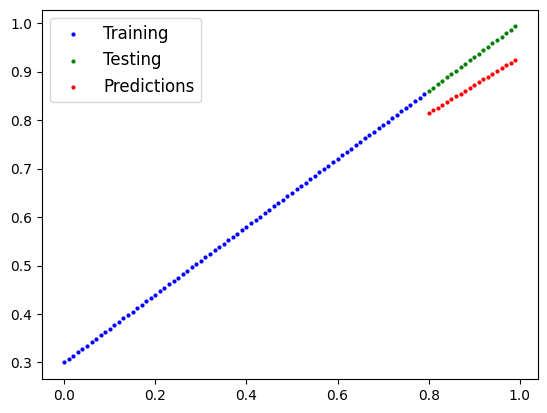

In [14]:
new_model = LRModel()
new_model.load_state_dict(torch.load("LRModel.pth"))
new_model.eval()
with torch.inference_mode():
    loaded_model_preds = new_model(X_test)

plot_data(X_train, y_train, X_test, y_test, loaded_model_preds)

## What Next?

As stated earlier this is a very simple example but demonstrates the whole PyTorch training process. We only used the CPU in this example but in the next example we will use the GPU to train a model on a larger dataset of images. But first we need to look at some data preprocessing techniques that we can use to prepare the data for training.
